# Breakpoints

## Review

We introduced the simplest form of human-in-the-loop -- just interrupting the graph -- along with streaming.

Of course, this does work because we have persistence in LangGraph.

## Goals

But, we don't want to actually do this. 

LangGraph offers several ways to get or update agent state systematically to support various human-in-the-loop workflow.

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

We'll show how this enables user approval.

--

To add: 

* Show how to get the state at a particular point. This will show you what the next node is. This is how you can check if its interrupted or not.

* Dynamic interrupts.

* Show with the API. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

## Breakpoints for human approval

Let's re-consider the simple agent that we worked with in Module 1. 

Let's assume that are concerned about tool use, and want to approve the agent to use specific tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [1]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

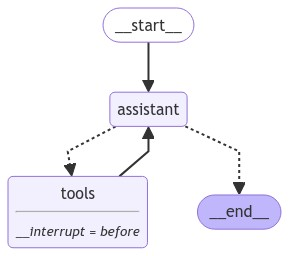

In [2]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZeOhAf1tvNjcnpQI7R0zb29f)
 Call ID: call_ZeOhAf1tvNjcnpQI7R0zb29f
  Args:
    a: 2
    b: 3


We can get the state easily, and look at the next node to call.

This is a cool way to see that it's interrupted.

In [8]:
state = graph.get_state(thread)
state.next

('tools',)

We can invoke the graph with `None` to resume!

In [4]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, lets bring these together with a specific user approval step.

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wpxciCjhhlOocKIOuYONFoET)
 Call ID: call_wpxciCjhhlOocKIOuYONFoET
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  yes


================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Dynamic breakpoints 

As we showed, you can add breakpoints before / after a node is executed. 

But oftentimes it may be helpful to dynamically interrupt the graph from inside a given node based on some condition. 

When doing so, it may also be helpful to include information about why that interrupt was raised.

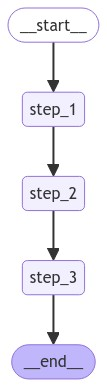

In [10]:
from typing import TypedDict
from langgraph.errors import NodeInterrupt

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt
    # if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

In [11]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


 If we inspect the graph state at this point, we can see the information on what node is set to execute next (step_2).
 
 We also see the node that raised the interrupt (also step_2), and additional information about the interrupt.

In [12]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='390137c6-9c2f-5dce-8c63-7389720145f2', name='step_2', error=None, interrupts=(Interrupt(when='during', value='Received input that is longer than 5 characters: hello world'),)),)


If we try to resume the graph from the breakpoint, we will simply interrupt again as our inputs and graph state haven't changed.

In [13]:
# NOTE: to resume the graph from a dynamic interrupt we use the same syntax as with regular interrupts -- we pass None as the input
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

Next, we'll show how to actually edit the graph state!